# Export Segmentation Masks
> How to save the outputs of your model to disk

- toc: true 
- badges: true
- comments: true
- categories: [Pytorch, fastai, cv]
- author: Thomas Capelle
- image: images/seg.png

![Segmentation](../images/seg.png)

You already have a trained model and want to run inference over a large dataset of images (in my case over 3kk images), how to do this efficiently and fast. We already have access to `fastai`'s `Learner.get_preds` method, but you need to be able to fit  in memory the full output, for my use case of segmentation masks over large images it is just not possible.
Let's build a solution to save the prediction to file using a dataloader to make inference fast and batched.

In [1]:
from fastai.vision.all import *

In [23]:
#hide
image_size = 256

site = 'Z_Tenesol'
zone = f'Zone_Salvagny_Tenesol_{image_size}'
DATA = Path('/DATA')/zone

WSISEG_STATS = [0.3114, 0.3166, 0.3946],[0.2587, 0.2598, 0.2958]

In [11]:
def is_gpu(dev=0):
    if torch.cuda.is_available():
        torch.cuda.set_device(dev)
        print(torch.cuda.get_device_name(dev))

In [12]:
is_gpu()

Quadro RTX 8000


we already have a model that is working good, for the sake of simplicity I am loading a `torchscript` model from file.

In [15]:
#hide
PATH = Path.home()/'SteadySun/suneye_dl_models/'

In [16]:
model = torch.jit.load(PATH/'model_checkpoints/unet_small_stage1.jit').cuda()

In [17]:
#hide
if not (DATA/'steadyeye_IA_database.hdf').exists():
    from steadyeye_dl.train import read_df
    df = read_df(DATA/'steadyeye_IA_database.csv', DATA, site='Z_Tenesol')
    df.to_hdf(DATA/'steadyeye_IA_database.hdf', key='df')
else:
    df = pd.read_hdf(DATA/'steadyeye_IA_database.hdf')

we have a dataframe with our data

In [18]:
df.head()

,group,image_path,elevation,azimuth,ghi_cs,kt,ghi
utc,,,,,,,
2019-01-08 10:04:16.970,0,/DATA/Zone_Salvagny_Tenesol_256/Z_Tenesol/camera_01/2019-01-08/image19-01-08_10-04-16-97.png,18.020898,1412.8,277.376311,0.181790,50.426096
2019-01-08 10:18:17.000,1,/DATA/Zone_Salvagny_Tenesol_256/Z_Tenesol/camera_01/2019-01-08/image19-01-08_10-18-17-00.png,18.975492,1412.8,295.647541,0.185127,54.741370
2019-01-08 10:19:16.980,1,/DATA/Zone_Salvagny_Tenesol_256/Z_Tenesol/camera_01/2019-01-08/image19-01-08_10-19-16-98.png,19.038769,1412.8,296.875387,0.177907,52.806228
2019-01-08 10:41:16.960,2,/DATA/Zone_Salvagny_Tenesol_256/Z_Tenesol/camera_01/2019-01-08/image19-01-08_10-41-16-96.png,20.297296,1412.8,321.138689,0.177493,57.007973
2019-01-08 10:42:16.950,2,/DATA/Zone_Salvagny_Tenesol_256/Z_Tenesol/camera_01/2019-01-08/image19-01-08_10-42-16-95.png,20.344993,1412.8,322.050887,0.194303,62.576990


## Inference on one image at a time

let's grab one image:

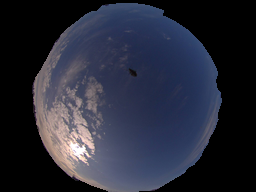

In [21]:
img_path = df.image_path.sample(1).item()
pil_img = load_image(img_path)
pil_img

We will use fastai transforms, but the same can be done using `torchvision.transforms`, 
```python
import torchvision.transforms as T
img_tfms = T.Compose([T.ToTensor(),
                      T.Normalize(*WSISEG_STATS)])
```

In [24]:
tfms = Pipeline([PILImage.create, 
                 ToTensor(), 
                 IntToFloatTensor(), 
                 Normalize.from_stats(*WSISEG_STATS, cuda=False)])

these transforms will convert the image to tensor, so we can pass it through the model

In [25]:
tensor_img = tfms(img_path)

into the model

In [26]:
raw_out = model(tensor_img.cuda())
raw_out.shape

torch.Size([1, 4, 192, 256])

this is a segmentation model with 4 classes, so the output has 4 channels. We need to postprocess this to get a 1 channel `uint8` image with values in [0,1,2,3]. We will also reconvert this output to `PIL` to save it later.

In [27]:
def postprocess(out):
    "Transform the output of the model to a uint8 mask"
    return PILMask.create(out.squeeze(0).argmax(0).cpu().numpy().astype(np.uint8))

it looks fine

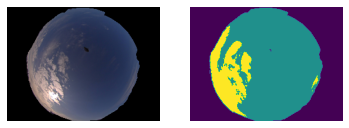

In [28]:
show_images([pil_img, postprocess(raw_out)])

Now, if we want to compute this process on all images (it is going to be slow...) let's do some refactor:

In [29]:
def predict_one(img_path):
    "evaluate `img_path` into model"
    tensor_img = tfms(img_path)
    with torch.no_grad():
        raw_out = model(tensor_img.cuda())
    return postprocess(raw_out)

<AxesSubplot:>

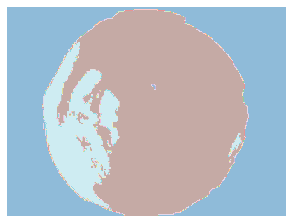

In [30]:
mask = predict_one(img_path)
mask.show()

We now want to save this image besides the original one. Let's leverage some `fastcore`'s magic and patch `pathlib.Path` to be able to put an arbitrary suffix on our images:
> Note: `Path.with_suffix` cannot put an arbitrary suffig with the `_GT` string before the extension

In [31]:
@patch
def my_suffix(self:Path, suffix=''):
    "replace the everything after the dot (including the dot) with `suffix`"
    path = self.with_suffix('')
    return path.parent/f'{path.name}{suffix}'

this way, our masks will be called `*_GT.png`

In [32]:
img_path, img_path.my_suffix('_GT.png')

(Path('/DATA/Zone_Salvagny_Tenesol_256/Z_Tenesol/camera_01/2019-10-24/image19-10-24_09-45-02-04.png'),
 Path('/DATA/Zone_Salvagny_Tenesol_256/Z_Tenesol/camera_01/2019-10-24/image19-10-24_09-45-02-04_GT.png'))

To process the full dataset one would do this:
- iterate over all images one by one
- compute inference on each
- save the postprocessed mask

In [ ]:
for img_path in progress_bar(df.image_path.to_list()):
    mask = predict_one(img_path)
    mask.save(img_path.my_suffix('_GT.png'))

## Batched images to files
> From DataLoader to files

Let's try to make better use of the GPU, we will feed batches of images all at once. We already have `DataLoaders` to do this, let's make a simple `TfmdDL` object, to stack our items with the transforms together. Here we need to split the transforms on the ones that are called after getting the item (the image path) and after stacking the tensors into a batch. The latter ones are computer on the GPU.

In [34]:
files = df.image_path.to_list()
dl = TfmdDL(files, 
            bs=64, 
            after_item=[PILImage.create, ToTensor()], 
            after_batch=[IntToFloatTensor, Normalize.from_stats(*WSISEG_STATS)], 
            device='cuda:0')

we get a nice batch of images (64 in this case) ready to feed the model

In [36]:
b = next(iter(dl))
b.shape

torch.Size([64, 3, 192, 256])

In [37]:
model(b).shape

torch.Size([64, 4, 192, 256])

Here we have performed inference on 64 images all at once, but the posprocessing need to happen imager per image anyway.
We have recover the original images filenames to be able to store the masks and make the maping with the original image. We kind of need a DataLoader for the filenames, here comes `chunked` function to the recue.
> Note: `chunked` splits the files on chunks of `bs` so we can iterate at the same time on the image paths.

In [38]:
fnames_bs = chunked(files, chunk_sz=64)

In my case, this solution is 10 times faster than doing the images one by one.

In [ ]:
for b, fnames in progress_bar(zip(dl, fnames_bs), total=len(files)//bs):
    with torch.no_grad():
        y = model(b)
    for torch_mask, fname in zip(y, fnames):
        mask = postprocess(torch_mask)
        mask.save(fname.my_suffix('_GT.png'))

## With a DataBlock
We can do the same thing with a data block

In [49]:
block = DataBlock(blocks=ImageBlock, 
                  get_x=ColReader('image_path'),
                  batch_tfms= [Normalize.from_stats(*WSISEG_STATS)],
                  splitter=lambda o: (range_of(o), []),
                 )

In [53]:
dl = block.dataloaders(df, bs=64, suffle=False).train

the `DataBlock` API generates a `DataLoaders` object, that is just a wrapper around a train/valid pair of `DataLoaders`. As we passed a dummy split (no split), the `valid` dataloader is empty, and we will use only the train one. Also, the batch in this case is composed of a tuple `(x,y)` where `y` is empty, hence we need to do `x, = b` (or `b[0]`)

In [55]:
for b, fnames in progress_bar(zip(dl, fnames_bs), total=len(files)//bs):
    with torch.no_grad():
        x, = b
        y = model(x)
    for torch_mask, fname in zip(y, fnames):
        mask = postprocess(torch_mask)
        mask.save(fname.my_suffix('_GT.png'))